# Test nested sampling

## Calculation time and optimizations

For $N_P$ around a dozen pitch periods, most time is actually spent in `core.kernelmatrix_root_convolved_gfd_oq()`, i.e. in calculating the model functions.

Relatively little time (30%) is spent in calculating $Z = R^T R + \sigma_n^2 I$ or in $chol(Z)$ (and those two have comparable runtimes).

The code could be optimized in various ways (for example avoid copying $R = hcat(R_1, R_2, ...)$, more intelligent calculating of `core.phi_singlepole()`). A fundamental way is to limit the correlation in time, i.e. the covariance matrix $Z = R^T R + \sigma_n^2 I$ can be approximated block-tridiagonal when a limit is set as to how many pitch periods the signal can travel. In this way:
1. We can avoid calculating many elements of $Z$ explicitly (note that it is symmetric anyway so we already have a factor 2 for free) by calculating only the tridiagonal blocks; 
2. ... and then perform a Cholesky on the tridiagonal block matrix as in here: https://www.intel.com/content/www/us/en/develop/documentation/mkl-cookbook/top/factoring-block-tridiagonal-symmetric-positive-definite-matrices.html

For moderate $N_P$ (around a dozen), this would yield 50% speedup. For large $N_P$, this would eventually yield huge savings.

**Other:**
- Jaxns: reduce GPU transfer time?
- 32bit instead of 64bit: Might be a huge speedup, but such low accuracy might be dangerous for `chol()` -- although our nugget terms are large O(0.01), so could be fine. JAXNS author states Gaussian processes require 64bit precision though. Naive implementation with just setting `jax.config.update("jax_enable_x64", True)` at the start yields errors when constructing priors (probably bceause nested sampling samples are 64bit floats). This could be viable if we "render" the priors and save them statically.

## Exploiting linearity

Model function is linear both in increasing $K$ *and* $N_P$.
We can exploit this using "nested model" inference.

Note: model can take very high $N_P$ in principle, but then $R$ becomes very sparse and we would need to take advantage of that for reasonable runtimes.
For example conjugate gradient (with preconditioning using a nearby live point) or block diagonal approximations.

## Amplitude priors

Trajectory on $f$ and $g$ ampltiudes: we use an envelope kernel with noise $\delta = 1$ because the parameters of source and filter envelope kernels (from period and reference formants, resp.) have been fitted in the *log* domain, so definitely their noise is unusable (since it is relative error, not absolute error), and their lengthscale correlations might be questioned, too. Ideally we would just fit new envelope trajectory kernels for $f$ and $g$ amplitudes to data, but this takes a lot of time. Or we could introduce their parameters into the inference to infer them dynamically, but this requires recalculating the bijectors at every step, and we have tried to avoid this. So we just stick with this strategy of keeping the lengthscale and the kernel, but setting the noise (nugget) to O(1) = 1. 

## Student-t?

I tried our Student-t likelihood (integrating over $\sigma$ of the noise) but the system is numerically too ill-conditioned  -- even though the SVD used in solving the least-squares problem can deal readily with the low rank arising; it just returns very large optimal ($>1e^9$) amplitudes for the least-squares problem, which then results in a very small likelihood due to amplitude regularization.

It also seems like SVD is actually slower than just multiplying $R^T R$ and doing Cholesky explicitly.

And in addition, the order factors become undefined if $M > N$, which happens when $N_P \sim 2$.

## Drifting of the GCIs

They tend to drift away from the given Praat estimates.
This could be partly due to the coupling with the lungs, because we do not model separate bandwidths during closed and open phases.

## Imputation

We can easily do data imputation with our work and see how well we predict.

## Residuals

Display residuals next to white noise -- gimmick

## Meaning of SNR

Mainly smoothing parameter because we know that real SNR is very high.

We often see phase transition during inference where we suddenly find a peak of high likelihood with higher SNR (about 20 dB) after slowly climbing uphill with SNRs around 10 dB.

In [1]:
%run init.ipy

from lib import constants
from lib import klatt
from lib import util

Exception: File `'init.ipy.py'` not found.

## Get some test data from VTRFormants ***TEST*** set

In [ ]:
import random
from vtr.prior import formant
from lib import timit

def rand_triple():
    vtr_root = timit.test_set(timit.VTRFORMANTS)
    timit_root = timit.test_set(timit.TIMIT)
    l = list(timit.yield_file_triples(vtr_root, timit_root))
    return random.choice(l)

fb_file, phn_file, wav_file = rand_triple()
fb_file, phn_file, wav_file

In [ ]:
import pathlib
fb_file, phn_file, wav_file = (
 pathlib.PosixPath('/home/marnix/thesis/py/../data/VTRFormants/TEST/DR3/MLNT0/SI1902.FB'),
 pathlib.PosixPath('/home/marnix/thesis/py/../data/TIMIT/TEST/DR3/MLNT0/SI1902.PHN'),
 pathlib.PosixPath('/home/marnix/thesis/py/../data/TIMIT/TEST/DR3/MLNT0/SI1902.WAV')
)

## Test noise sigma prior

Test the noise sigma prior (bijector). We put a mean at -20 dB and floor it at the noise floor. Relative uncertainty is 100% leading to a nois power dB of roughly -20 +/- 7.5 dB.

In [2]:
from inv import model

b = model.noise_sigma_bijector()

noise_sigmas = b.forward(randn(100000))

noise_power_dbs = 20*np.log10(noise_sigmas)

hist(noise_power_dbs, bins=50);

np.mean(noise_power_dbs), np.std(noise_power_dbs)

ModuleNotFoundError: No module named 'inv'

## Test model with random hyper priors

[Memory]4.3s, 0.1min    : Loading get_aplawd_training_pairs_subset...
[Memory]37.7s, 0.6min   : Loading run_nested...
[Memory]39.2s, 0.7min   : Loading run_nested...
[Memory]40.6s, 0.7min   : Loading run_nested...
[Memory]42.1s, 0.7min   : Loading run_nested...
NP = 4
Number of data points: 379
Number of model dimensions: 82


({'kernel_name': 'Matern32Kernel',
  'kernel_M': 128,
  'use_oq': True,
  'impose_null_integral': True},
 PoleZeroFilter(4))

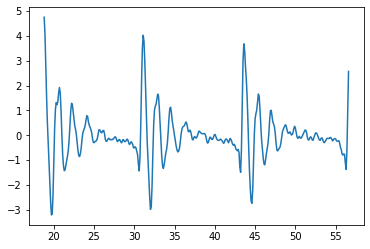

In [5]:
from inv import process
from vtr.prior import filter
import jax

source_config = dict(
    kernel_name = "Matern32Kernel",
    kernel_M = 128,
    use_oq = True,
    impose_null_integral = True
)

vtfilter = filter.PZ(4, numpy_backend=jax.numpy, scipy_backend=jax.scipy)

hyper = process.make_rand_hyper(
    (fb_file, phn_file, wav_file),
    source_config = source_config,
    vtfilter = vtfilter,
    process_data_kwargs=dict(max_NP = 4, prepend=1)
)

plot(hyper['data']['t'], hyper['data']['d'])
print("NP =", hyper['data']['NP'])
print("Number of data points:", len(hyper['data']['d']))
print("Number of model dimensions:", model.ndim(hyper))

display(klatt.play(hyper['data']['t'], hyper['data']['d']))

hyper['source'], hyper['filter']

In [6]:
prior = model.theta_trajectory_prior(hyper)
theta = prior.sample(seed=jaxkey())
theta, prior.log_prob(theta)

[Memory]44.3s, 0.7min   : Loading get_aplawd_training_pairs_subset...
[Memory]44.6s, 0.7min   : Loading posterior_of_fitted_lf_values...
[Memory]44.7s, 0.7min   : Loading run_nested...
[Memory]44.9s, 0.7min   : Loading get_aplawd_training_pairs_subset...
[Memory]51.9s, 0.9min   : Loading posterior_of_fitted_TFB_values...
[Memory]52.2s, 0.9min   : Loading run_nested...
[Memory]52.2s, 0.9min   : Loading get_vtrformants_training_data...
[Memory]69.2s, 1.2min   : Loading run_nested...
[Memory]70.0s, 1.2min   : Loading run_nested...
[Memory]70.9s, 1.2min   : Loading run_nested...
[Memory]71.7s, 1.2min   : Loading run_nested...
[Memory]71.8s, 1.2min   : Loading get_vtrformants_training_data...


({'noise_sigma': DeviceArray(0.04981101, dtype=float64),
  'delta': DeviceArray(0.99360919, dtype=float64),
  'source': DeviceArray([[ 1.06579615,  0.09883092, 13.45890458,  0.79277799],
               [ 1.35179621,  0.1375015 , 12.65535672,  0.83620284],
               [ 1.67155112,  0.16128098, 13.23142836,  0.75300745],
               [ 1.95472979,  0.19555802, 12.7221936 ,  0.79330942]],            dtype=float64),
  'filter': DeviceArray([[ 538.91348092, 2052.55451406, 2297.69392646, 2740.55730732,
                  53.67896823,   22.36249434, 1215.07072517,  820.2503897 ],
               [ 561.63666631, 2058.50090002, 2291.09059386, 2793.40331638,
                  52.61264604,   22.99861763, 1011.1791112 , 1005.42147664],
               [ 587.98883794, 2102.41753785, 2201.25613053, 2839.90045097,
                  50.12173401,   24.98467799,  821.90733706, 1008.15732024],
               [ 630.99413946, 2231.44178865, 2174.20527484, 2883.98218741,
                  47.79188648,   

Show the possible model functions $f(t;\theta)$ for a sampled $\theta$. We need to find a $\theta$ for which **most** -- not just a few -- of these samples are close to the data. **This is Bayesian regularization in action.**

We can see that the general amplitude magnitude is reasonable, although for larger $K$ for PZ and $N_P$ it may take more samples to hit O(1) range. This is because of interpitch-period correlations and the heavier tails of the energy distribution of the PZ model.

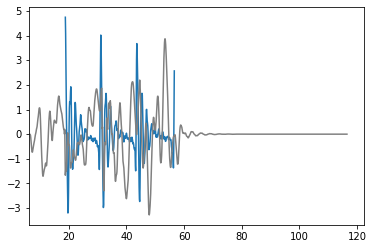

In [7]:
theta = prior.sample(seed=jaxkey())
noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)

hyper2 = process.hyper_fullt(hyper)

R = model.full_kernelmatrix_root(
    delta, theta_source, theta_filter, hyper2, convolve=True
)

plot(hyper['data']['t'], hyper['data']['d'])

nsamp = 1
for _ in range(nsamp):
    w = model.randf(hyper)
    f = R @ w
    plot(hyper['data']['fullt'], f, color='grey', alpha=1/sqrt(nsamp))

def setxlim(f, margin=0.05):
    ts = hyper['data']['fullt'][f != 0.]
    xlim(ts[0]*(1-margin), ts[-1]*(1+margin))

setxlim(f)

klatt.play(hyper['data']['t'], f)

We can see the correlations in the $f$ amplitudes well.

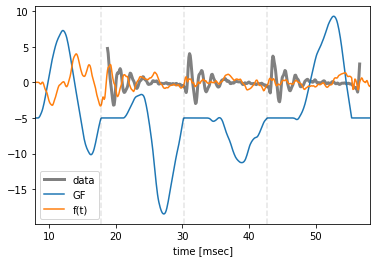

In [8]:
theta = prior.sample(seed=jaxkey())
noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)
offset = model.get_offset(delta, theta_source, hyper)

hyper2 = process.hyper_fullt(hyper)

R = model.full_kernelmatrix_root(
    delta, theta_source, theta_filter, hyper2, convolve=True, correlatef=False
)

R_gfd = model.full_kernelmatrix_root(
    delta, theta_source, theta_filter, hyper2, 
    convolve=False, integrate=True, correlatef=False
)

w = model.randf(hyper)

plot(hyper['data']['t'], hyper['data']['d'], color="grey", label="data", lw=3)

plot(hyper['data']['fullt'], R_gfd @ w - 5, label="GF")
plot(hyper['data']['fullt'], R @ w, label="f(t)")
for tp in offset: axvline(tp, ls="--", color="black", alpha=.1)
xlabel("time [msec]")
setxlim(R_gfd @ w)
legend();

## Test NS algorithm

In [9]:
import dynesty
import scipy
from inv import model

theta_bijector = model.theta_trajectory_bijector(hyper)
    
@jax.jit
def loglike(w):
    theta = theta_bijector.forward(w)
    logl = model.full_likelihood(theta, hyper)
    return logl

ptform = scipy.special.ndtri

ndim = model.ndim(hyper)
ndim

[Memory]94.3s, 1.6min   : Loading posterior_of_fitted_lf_values...
[Memory]94.3s, 1.6min   : Loading run_nested...
[Memory]94.3s, 1.6min   : Loading posterior_of_fitted_TFB_values...
[Memory]94.3s, 1.6min   : Loading run_nested...


82

In [10]:
w = ptform(rand(ndim))
loglike(w), theta_bijector.forward(w)

(DeviceArray(-10661.8000078, dtype=float64),
 {'noise_sigma': DeviceArray(0.06285791, dtype=float64),
  'delta': DeviceArray(-0.25469078, dtype=float64),
  'source': DeviceArray([[ 2.29954097,  0.20344518, 12.35396284,  0.94218868],
               [ 2.07875802,  0.18581807, 11.92689816,  0.95720523],
               [ 2.27083762,  0.20637846, 12.15610072,  0.95137912],
               [ 2.30041528,  0.21185491, 12.09807387,  0.9728668 ]],            dtype=float64),
  'filter': DeviceArray([[ 685.6869197 , 1442.48042486, 2500.0811649 , 3320.1720727 ,
                  53.79747358,   46.97188104,  676.23234949, 1350.12851669],
               [ 664.73007872, 1295.31759598, 2534.34910292, 3440.52444307,
                  61.09662679,   42.67948458,  547.54487522, 1402.22395328],
               [ 640.35961728, 1228.47828933, 2526.84102984, 3504.58880116,
                  64.55057794,   40.3181063 ,  518.0210645 , 1318.7636221 ],
               [ 635.62857979, 1204.90467216, 2491.96896683, 35

In [17]:
SAMPLERARGS = {'sample': 'rslice', 'first_update': {'min_eff': 5.}}
RUNARGS = {'save_bounds': False, 'maxcall': int(1e7)}

sampler = dynesty.NestedSampler(
    loglike, ptform, ndim, nlive=ndim, **SAMPLERARGS
)

sampler.run_nested(**RUNARGS)
results = sampler.results

/home/marnix/thesis/py/venv/lib/python3.10/site-packages/dynesty/dynesty.py:575: UserWarning: Beware! Having `nlive <= 2 * ndim` is extremely risky!
  warnings.warn(
7982it [5:10:40,  2.34s/it, +82 | bound: 677 | nc: 1 | ncall: 3634244 | eff(%):  0.222 | loglstar:   -inf < 183.435 <    inf | logz: 89.050 +/-  0.981 | dlogz:  0.001 >  0.091]


In [25]:
import pickle

# open a file, where you ant to store the data
file = open('golden-example.pickle', 'wb')

# dump information to that file
pickle.dump(results, file)

# close the file
file.close()

Summary
nlive: 82
niter: 7982
ncall: 3634162
eff(%):  0.222
logz: 89.050 +/-  1.044


None

'Information (bans)'

33.55881945277564

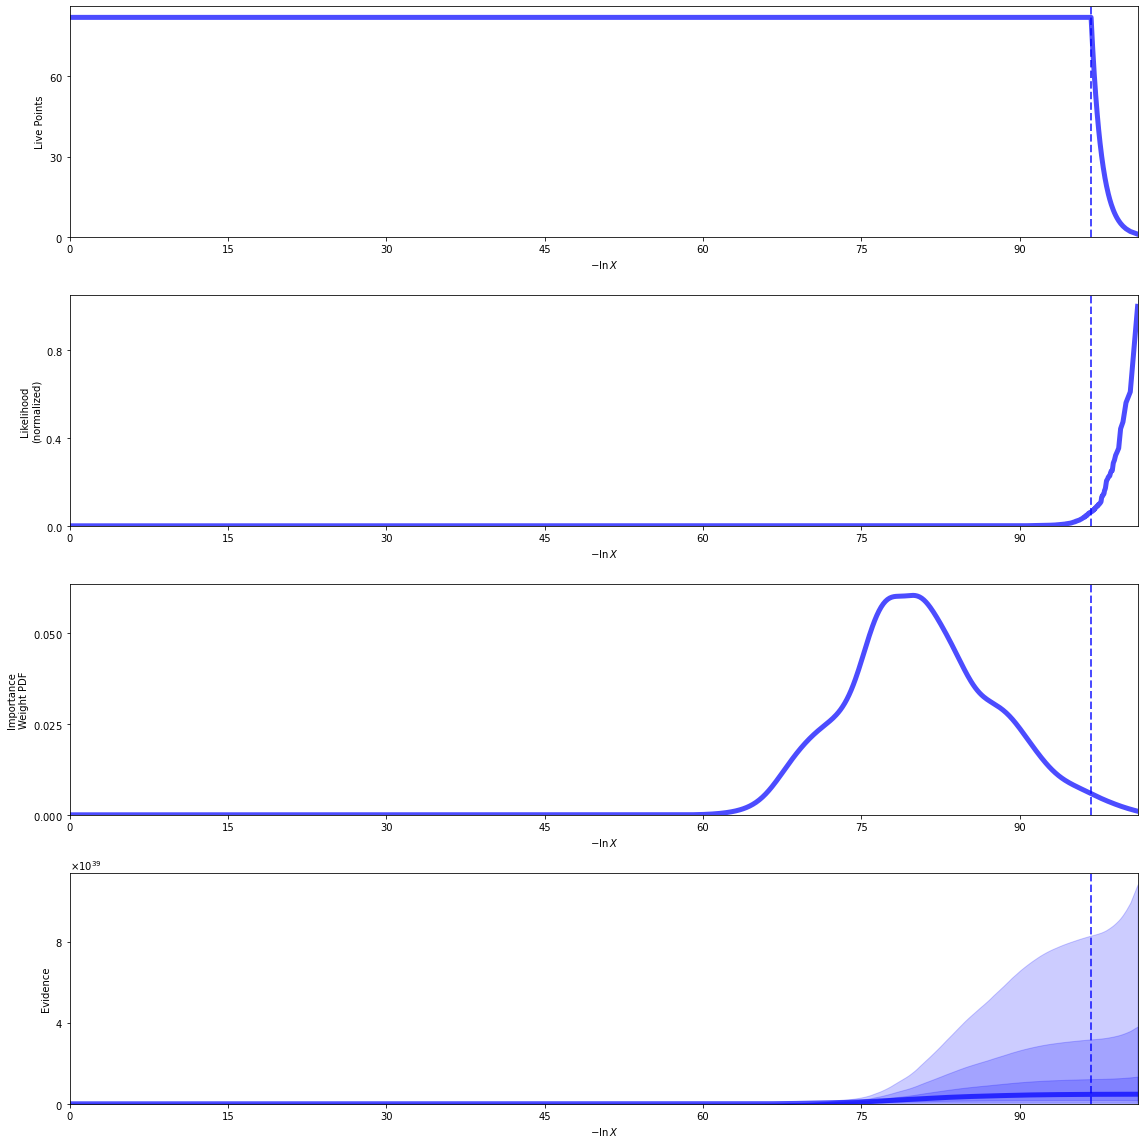

Quantiles:
$x_{1}$ [(0.025, 0.10659064519944204), (0.5, 0.20995300392600647), (0.975, 0.2826556323496651)]
Quantiles:
$x_{2}$ [(0.025, -0.34965686591932643), (0.5, -0.20832550281236292), (0.975, -0.08776472028946472)]
Quantiles:
$x_{3}$ [(0.025, -0.015073251057988166), (0.5, 0.2957281312464733), (0.975, 0.658392582947851)]
Quantiles:
$x_{4}$ [(0.025, -0.9451655485762078), (0.5, -0.3228417740621276), (0.975, 0.2827160851806026)]
Quantiles:
$x_{5}$ [(0.025, -0.3374006360460365), (0.5, 0.08886275286517767), (0.975, 0.49384579915508786)]
Quantiles:
$x_{6}$ [(0.025, 0.45291535141682704), (0.5, 0.8402121173125073), (0.975, 1.2750194966425967)]
Quantiles:
$x_{7}$ [(0.025, -1.692060095585949), (0.5, -1.3883032266347972), (0.975, -1.1132954670613964)]
Quantiles:
$x_{8}$ [(0.025, -0.9315718602122224), (0.5, -0.48186934695283834), (0.975, -0.15873546458949622)]
Quantiles:
$x_{9}$ [(0.025, -0.43637805792602696), (0.5, -0.026255252983434108), (0.975, 0.27869317613340056)]
Quantiles:
$x_{10}$ [(0.02

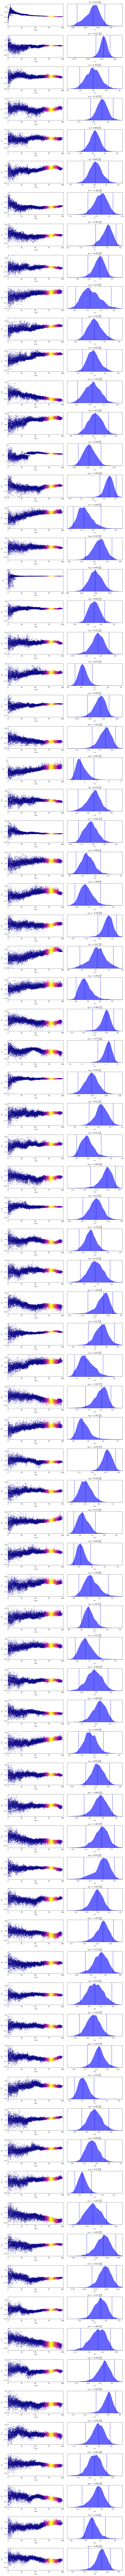

In [18]:
util.dyplot(results, runplot=True, traceplot=True, cornerplot=False)

In [19]:
def lstsq(R, y, noise_power):
    D = jnp.eye(R.shape[1])
    Z = noise_power * D + R.T @ R
    L, lower = jax.scipy.linalg.cho_factor(Z, lower=True, check_finite=False)
    b = R.T @ y
    x = jax.scipy.linalg.cho_solve((L, lower), b, check_finite=False)
    return x

0	log L = 165.00361866574826	SNR [dB] = 18.976186881176382
1	log L = 167.08889703766602	SNR [dB] = 19.18107475087227
2	log L = 163.55155365885662	SNR [dB] = 18.96569437471499
3	log L = 148.9714275127705	SNR [dB] = 18.41772149994394
4	log L = 168.60832520720157	SNR [dB] = 19.110895044433207


DeviceArray(0.49529418, dtype=float64)

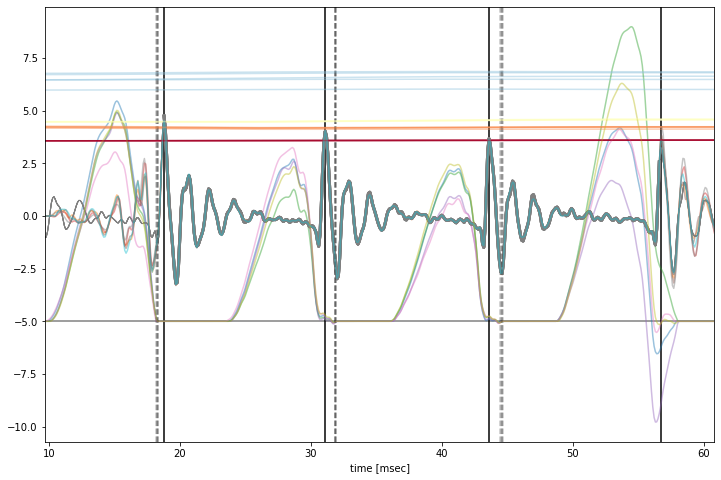

In [24]:
nsamp = 5

w_samples = util.resample_equal(results, nsamp)

figsize(12, 8)
axhline(-5, color="grey")

for pest in hyper['data']['pulse_estimate']: axvline(pest, color="black")

for i, w_sample in enumerate(w_samples):
    print(i, end='\t')
    
    theta = theta_bijector.forward(w_sample)
    print("log L =", model.full_likelihood(theta, hyper), end='\t')

    noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)
    offset = model.get_offset(delta, theta_source, hyper)
    print("SNR [dB] =", -20*log10(noise_sigma))

    R = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper, convolve=True
    )

    f_mean = lstsq(R, hyper['data']['d'], noise_sigma**2)

    hyper2 = process.hyper_fullt(hyper)
    R2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=True
    )

    R_gfd2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=False, integrate=True
    )

    ft = R2 @ f_mean
    gf = R_gfd2 @ f_mean

    
    alpha = 1/sqrt(nsamp)
    plot(hyper['data']['fullt'], hyper['data']['fulld'], color="grey", label="data", lw=1)
    plot(hyper['data']['t'], hyper['data']['d'], color="grey", label="data", lw=3)
    plot(hyper['data']['fullt'], gf - 5, label="GF", alpha=alpha)
    plot(hyper['data']['fullt'], ft, label="f(t)", alpha=alpha)
    for tp in offset: axvline(tp, ls="--", color="black", alpha=.5*alpha)
    xlabel("time [msec]")
    setxlim(gf)
    #legend()
    
    for k, x in enumerate(theta_filter['x'].T):
        x_interp = np.interp(
            hyper['data']['fullt'], offset + theta_source['T']/2, x
        )
        plot(
            hyper['data']['fullt'], 3 + x_interp/1000,
            alpha=alpha, color=plt.cm.RdYlBu(k/hyper['filter'].K)
        )

    #display(klatt.play(hyper['data']['t'], hyper['data']['d']))
    #display(klatt.play(hyper['data']['t'], ft))

delta

In [21]:
model.unpack_theta(theta, hyper)

(DeviceArray(0.11374651, dtype=float64),
 DeviceArray(0.56734231, dtype=float64),
 {'Oq': DeviceArray([0.60827935, 0.58360774, 0.66001249, 0.68007386], dtype=float64),
  'T': DeviceArray([13.11337696, 13.54490366, 12.7183638 , 13.41383445], dtype=float64),
  'r': DeviceArray([0.10426805, 0.09893074, 0.101643  , 0.121984  ], dtype=float64),
  'var_sigma': DeviceArray([2.47371748, 2.41724145, 2.46141922, 2.71608196], dtype=float64)},
 {'g': DeviceArray([[ 2.03942343, -0.98030658, -1.91727031, -0.00426124,
                 1.93055632, -3.26363726, -2.61475232, -0.62857465],
               [ 2.79864287,  1.07435017, -0.92040629,  0.1620048 ,
                 1.59857165, -2.04764893, -1.64268509, -1.25294159],
               [ 2.62942171,  0.05792613, -0.71133777, -0.18841156,
                 1.86783536, -2.3512042 , -2.11828094,  0.94197768],
               [ 1.91754258, -0.12966994, -1.90454527, -0.90626767,
                 2.19458547, -1.85867843, -1.40587546, -1.35679466]],           

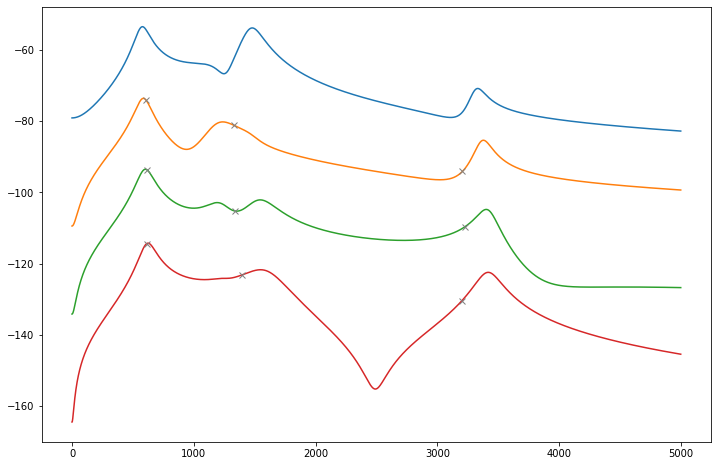

In [22]:
f = constants.spectrum_frequencies()

powers = jax.vmap(hyper['filter'].transfer_function_power_dB, (None, 0, 0, 0))(
    f, theta_filter['x'], theta_filter['y'], theta_filter['g']
)

for i, power in enumerate(powers):
    plot(f, power - i*20)
    
    F = hyper['data']['F_estimate'][i,:]
    estim = np.interp(F, f, power - i*20)
    plot(F, estim, 'x', color="grey")

## Without `Oq`

In [23]:
hyper_woq = process.hyper_variation(hyper, use_oq=False)

In [ ]:
theta_bijector = model.theta_trajectory_bijector(hyper_woq)
    
@jax.jit
def loglike(w):
    theta = theta_bijector.forward(w)
    logl = model.full_likelihood(theta, hyper_woq)
    return logl

ptform = scipy.special.ndtri

ndim = model.ndim(hyper_woq)
ndim

In [ ]:
w = ptform(rand(ndim))
loglike(w), theta_bijector.forward(w)

In [ ]:
SAMPLERARGS = {'sample': 'rslice', 'first_update': {'min_eff': 2.}}
RUNARGS = {'save_bounds': False, 'maxcall': int(1e7)}

sampler = dynesty.NestedSampler(
    loglike, ptform, ndim, nlive=ndim*3, **SAMPLERARGS
)

sampler.run_nested(**RUNARGS)
results = sampler.results

In [ ]:
util.dyplot(results, cornerplot=False)

In [ ]:
nsamp = 10

w_samples = util.resample_equal(results, nsamp)

figsize(12, 8)
axhline(-5, color="grey")

for pest in hyper_woq['data']['pulse_estimate']: axvline(pest, color="black")

for i, w_sample in enumerate(w_samples):
    print(i, end='\t')
    
    theta = theta_bijector.forward(w_sample)
    print("log L =", model.full_likelihood(theta, hyper_woq), end='\t')

    noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper_woq)
    offset = model.get_offset(delta, theta_source, hyper_woq)
    print("SNR [dB] =", -20*log10(noise_sigma))

    R = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper_woq, convolve=True
    )

    f_mean = lstsq(R, hyper_woq['data']['d'], noise_sigma**2)

    hyper_woq2 = process.hyper_fullt(hyper_woq)
    R2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper_woq2, convolve=True
    )

    R_gfd2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper_woq2, convolve=False, integrate=True
    )

    ft = R2 @ f_mean
    gf = R_gfd2 @ f_mean

    
    alpha = 1/sqrt(nsamp)
    plot(hyper_woq['data']['fullt'], hyper_woq['data']['fulld'], color="grey", label="data", lw=1)
    plot(hyper_woq['data']['t'], hyper_woq['data']['d'], color="grey", label="data", lw=3)
    plot(hyper_woq['data']['fullt'], gf - 5, label="GF", alpha=alpha)
    plot(hyper_woq['data']['fullt'], ft, label="f(t)", alpha=alpha)
    for tp in offset: axvline(tp, ls="--", color="black", alpha=.5*alpha)
    xlabel("time [msec]")
    setxlim(gf)
    #legend()
    
    for k, x in enumerate(theta_filter['x'].T):
        x_interp = np.interp(
            hyper_woq['data']['fullt'], offset + theta_source['T']/2, x
        )
        plot(
            hyper_woq['data']['fullt'], 3 + x_interp/1000,
            alpha=alpha, color=plt.cm.RdYlBu(k/hyper_woq['filter'].K)
        )

delta

In [ ]:
model.unpack_theta(theta, hyper_woq)

## With OQ and PZ

In [ ]:
hyper_woq = process.hyper_variation(
    hyper, use_oq=True,
    filter=filter.PZ(3, numpy_backend=jax.numpy, scipy_backend=jax.scipy)
)

In [ ]:
theta_bijector = model.theta_trajectory_bijector(hyper_woq)
    
@jax.jit
def loglike(w):
    theta = theta_bijector.forward(w)
    logl = model.full_likelihood(theta, hyper_woq)
    return logl

ptform = scipy.special.ndtri

ndim = model.ndim(hyper_woq)
ndim

In [ ]:
w = ptform(rand(ndim))
loglike(w), theta_bijector.forward(w)

In [ ]:
SAMPLERARGS = {'sample': 'rslice', 'first_update': {'min_eff': 2.}}
RUNARGS = {'save_bounds': False, 'maxcall': int(1e7)}

sampler = dynesty.NestedSampler(
    loglike, ptform, ndim, nlive=ndim*3, **SAMPLERARGS
)

sampler.run_nested(**RUNARGS)
results = sampler.results

In [ ]:
util.dyplot(results, cornerplot=False)

In [ ]:
nsamp = 10

w_samples = util.resample_equal(results, nsamp)

figsize(12, 8)
axhline(-5, color="grey")

for pest in hyper_woq['data']['pulse_estimate']: axvline(pest, color="black")

for i, w_sample in enumerate(w_samples):
    print(i, end='\t')
    
    theta = theta_bijector.forward(w_sample)
    print("log L =", model.full_likelihood(theta, hyper_woq), end='\t')

    noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper_woq)
    offset = model.get_offset(delta, theta_source, hyper_woq)
    print("SNR [dB] =", -20*log10(noise_sigma))

    R = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper_woq, convolve=True
    )

    f_mean = lstsq(R, hyper_woq['data']['d'], noise_sigma**2)

    hyper_woq2 = process.hyper_fullt(hyper_woq)
    R2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper_woq2, convolve=True
    )

    R_gfd2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper_woq2, convolve=False, integrate=True
    )

    ft = R2 @ f_mean
    gf = R_gfd2 @ f_mean

    
    alpha = 1/sqrt(nsamp)
    plot(hyper_woq['data']['fullt'], hyper_woq['data']['fulld'], color="grey", label="data", lw=1)
    plot(hyper_woq['data']['t'], hyper_woq['data']['d'], color="grey", label="data", lw=3)
    plot(hyper_woq['data']['fullt'], gf - 5, label="GF", alpha=alpha)
    plot(hyper_woq['data']['fullt'], ft, label="f(t)", alpha=alpha)
    for tp in offset: axvline(tp, ls="--", color="black", alpha=.5*alpha)
    xlabel("time [msec]")
    setxlim(gf)
    #legend()
    
    for k, x in enumerate(theta_filter['x'].T):
        x_interp = np.interp(
            hyper_woq['data']['fullt'], offset + theta_source['T']/2, x
        )
        plot(
            hyper_woq['data']['fullt'], 3 + x_interp/1000,
            alpha=alpha, color=plt.cm.RdYlBu(k/hyper_woq['filter'].K)
        )

delta

In [ ]:
model.unpack_theta(theta, hyper_woq)

## Without OQ, with PZ

In [ ]:
hyper_woq = process.hyper_variation(
    hyper, use_oq=False,
    filter=filter.PZ(3, numpy_backend=jax.numpy, scipy_backend=jax.scipy)
)

In [ ]:
theta_bijector = model.theta_trajectory_bijector(hyper_woq)
    
@jax.jit
def loglike(w):
    theta = theta_bijector.forward(w)
    logl = model.full_likelihood(theta, hyper_woq)
    return logl

ptform = scipy.special.ndtri

ndim = model.ndim(hyper_woq)
ndim

In [ ]:
w = ptform(rand(ndim))
loglike(w), theta_bijector.forward(w)

In [ ]:
SAMPLERARGS = {'sample': 'rslice', 'first_update': {'min_eff': 2.}}
RUNARGS = {'save_bounds': False, 'maxcall': int(1e7)}

sampler = dynesty.NestedSampler(
    loglike, ptform, ndim, nlive=ndim*3, **SAMPLERARGS
)

sampler.run_nested(**RUNARGS)
results = sampler.results

In [ ]:
util.dyplot(results, cornerplot=False)

In [ ]:
nsamp = 10

w_samples = util.resample_equal(results, nsamp)

figsize(12, 8)
axhline(-5, color="grey")

for pest in hyper_woq['data']['pulse_estimate']: axvline(pest, color="black")

for i, w_sample in enumerate(w_samples):
    print(i, end='\t')
    
    theta = theta_bijector.forward(w_sample)
    print("log L =", model.full_likelihood(theta, hyper_woq), end='\t')

    noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper_woq)
    offset = model.get_offset(delta, theta_source, hyper_woq)
    print("SNR [dB] =", -20*log10(noise_sigma))

    R = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper_woq, convolve=True
    )

    f_mean = lstsq(R, hyper_woq['data']['d'], noise_sigma**2)

    hyper_woq2 = process.hyper_fullt(hyper_woq)
    R2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper_woq2, convolve=True
    )

    R_gfd2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper_woq2, convolve=False, integrate=True
    )

    ft = R2 @ f_mean
    gf = R_gfd2 @ f_mean

    
    alpha = 1/sqrt(nsamp)
    plot(hyper_woq['data']['fullt'], hyper_woq['data']['fulld'], color="grey", label="data", lw=1)
    plot(hyper_woq['data']['t'], hyper_woq['data']['d'], color="grey", label="data", lw=3)
    plot(hyper_woq['data']['fullt'], gf - 5, label="GF", alpha=alpha)
    plot(hyper_woq['data']['fullt'], ft, label="f(t)", alpha=alpha)
    for tp in offset: axvline(tp, ls="--", color="black", alpha=.5*alpha)
    xlabel("time [msec]")
    setxlim(gf)
    #legend()
    
    for k, x in enumerate(theta_filter['x'].T):
        x_interp = np.interp(
            hyper_woq['data']['fullt'], offset + theta_source['T']/2, x
        )
        plot(
            hyper_woq['data']['fullt'], 3 + x_interp/1000,
            alpha=alpha, color=plt.cm.RdYlBu(k/hyper_woq['filter'].K)
        )

delta

In [ ]:
model.unpack_theta(theta, hyper_woq)

## Test Hamiltonian NS

Much slower than normal slice sampling >:(

In [25]:
import tensorflow_probability.substrates.jax.bijectors as tfb

def theta_trajectory_bijector_unit_cube(hyper):
    unit_cube_bijector = tfb.Invert(tfb.NormalCDF())
    theta_bijector = model.theta_trajectory_bijector(hyper)
    return tfb.Chain([
        theta_bijector, unit_cube_bijector
    ])

theta_bijector_unit = theta_trajectory_bijector_unit_cube(hyper)
ndim = model.ndim(hyper)
theta_bijector_unit.forward(rand(ndim))

[Memory]1268.7s, 21.1min: Loading posterior_of_fitted_lf_values...
[Memory]1268.7s, 21.1min: Loading run_nested...
[Memory]1268.7s, 21.1min: Loading posterior_of_fitted_TFB_values...
[Memory]1268.8s, 21.1min: Loading run_nested...


{'noise_sigma': DeviceArray(0.17343386, dtype=float64),
 'delta': DeviceArray(1.83252331, dtype=float64),
 'source': DeviceArray([[ 0.90711013,  0.07825752, 12.45242959,  0.97394468],
              [ 0.73889899,  0.06420927, 12.46682939,  0.96958929],
              [ 0.80268489,  0.05735568, 12.96802345,  0.95837203],
              [ 0.69330605,  0.04936699, 13.48213793,  0.95840226]],            dtype=float64),
 'filter': DeviceArray([[ 325.28476718,  573.15084821, 1513.67673353, 2637.30960104,
                217.21932212,   51.3478652 ,  368.85985619,   59.61544393],
              [ 321.87367932,  581.71577683, 1481.27647435, 2697.04986718,
                215.9054001 ,   44.49798399,  396.30079198,   64.30431895],
              [ 326.83801235,  606.50546138, 1460.61442625, 2755.46688795,
                211.06045445,   42.72475483,  420.4917623 ,   74.18440694],
              [ 334.63922047,  667.91647076, 1479.43897856, 2807.30638224,
                217.92016554,   38.72602854,  

In [29]:
import dynesty
import scipy

@jax.jit
def loglike(u):
    theta = theta_bijector_unit.forward(u)
    logl = model.full_likelihood(theta, hyper)
    return logl

ptform = lambda x: x

grad_u = jax.jit(jax.grad(loglike))

jax.value_and_grad(loglike)(rand(ndim)), grad_u(rand(ndim))

((DeviceArray(-4086.50719757, dtype=float64),
  DeviceArray([ 1.91910072e+04, -1.66784098e+03,  4.95826872e+03,
                2.09310480e+02,  1.65062985e+02,  3.57569623e+01,
                2.27962243e+03,  9.07694591e+01,  3.55306876e+01,
                1.21515054e+02,  6.30459903e+02,  4.68163874e+02,
                1.25069867e+03,  5.00322035e+01,  2.70893881e+02,
                2.22391615e+01,  3.74733611e+01, -2.90071763e+01,
                3.99837835e+03,  5.54729816e+02,  1.18594116e+02,
               -1.48480496e+01, -2.33973291e+03, -2.15227557e+02,
               -2.42302870e+02, -6.62605922e+01, -4.94198444e+02,
               -8.04380296e+00, -2.38307200e+00, -1.80263003e+01,
                1.06168897e+02,  7.33142476e+01,  2.03292373e+01,
                1.96942523e+00, -1.11727209e+03,  7.97127938e+01,
                8.15469297e+01,  1.69401951e+00,  9.51988215e+02,
                8.46837008e+01,  3.34344545e+01,  2.16786819e+00,
               -7.17056053e+02

In [36]:
SAMPLERARGS = {'sample': 'hslice', 'bound': 'cubes'}
RUNARGS = {'save_bounds': False, 'maxcall': int(1e6)}

sampler = dynesty.NestedSampler(
    loglike, ptform, ndim, nlive=ndim, gradient=grad_u, **SAMPLERARGS
)

sampler.run_nested(**RUNARGS)
results = sampler.results

316it [02:42,  1.95it/s, bound: 0 | nc: 1339 | ncall: 23151 | eff(%):  1.365 | loglstar:   -inf < -566.128 <    inf | logz: -575.017 +/-  0.324 | dlogz: 354.771 >  0.091] 


KeyboardInterrupt: 